In [2]:
import math
from PIL import Image, ImageEnhance, ImageFilter
from skimage.exposure import cumulative_distribution
import numpy as np
from skimage import data, img_as_float, img_as_ubyte, exposure, io, color
from skimage.filters import threshold_otsu
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### you can use either porespy or porenetwork (openpnm) for this task
- https://openpnm.org/examples/reference/simulations/size_factors_and_transport_conductance.html
- https://porespy.org/examples/metrics/tutorials/regionprops_3d.html
- comparison of porosity calculation due to porespy and openpnm openpnm: https://openpnm.org/examples/applications/porosity.html

In this hometask you will work with 3d-samples and find following properties:
- porosity
- pore size distribution
- surface area
- Euler number
- shape factor 
- and find representative elementary volume (REV)

1) Denoise and binarize the sample:
    
- Take provided slice;
- Utilize techniques you got familiar during HW1 and HW2 (denoising, thresholding, half-toning, etc); You should decide by yourself which transformations are the most suitable;

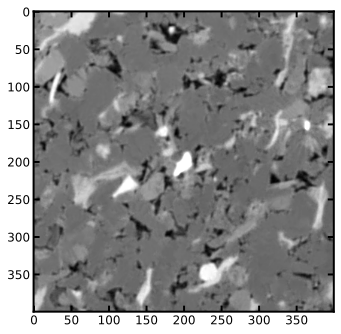

In [38]:
# возьмем этот образец и извлечем 5 слайсов
im1 = np.load('sample1.npy')
plt.imshow(im1[45,:,:], cmap='gray')

In [13]:
im1.shape

(400, 400, 400)

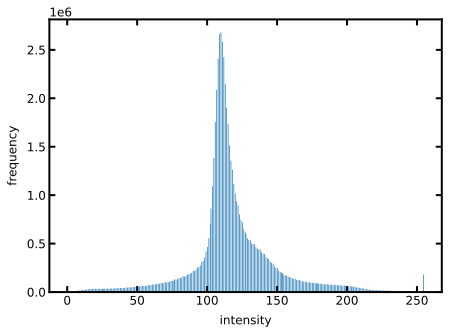

In [41]:
def plot_hist(img):
    plt.hist(np.array(img).ravel(), bins=500)
    plt.ylabel('frequency')
    plt.xlabel('intensity')
    plt.show()
    
    
plot_hist(im1)

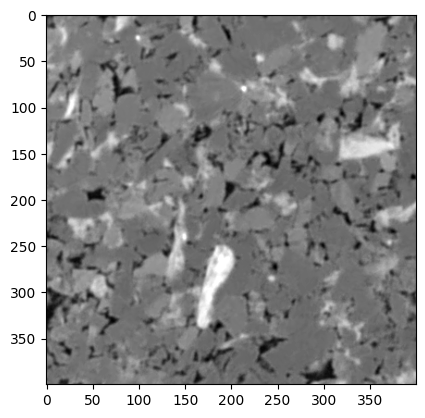

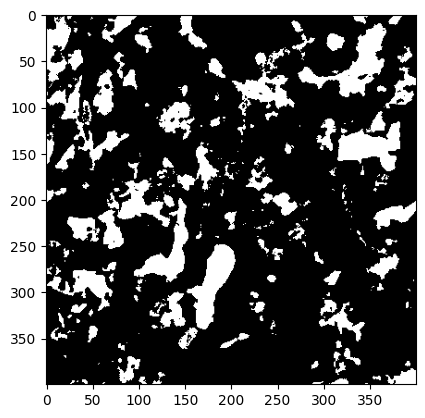

In [14]:
# global Otsu trhesholding
thresh = threshold_otsu(im1)
binary = im1 > thresh
plt.imshow(im1[0], cmap=plt.cm.gray)
plt.show()
plt.imshow(binary[0], cmap=plt.cm.gray)
plt.show()

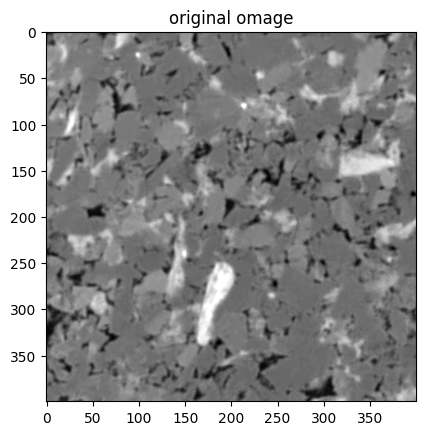

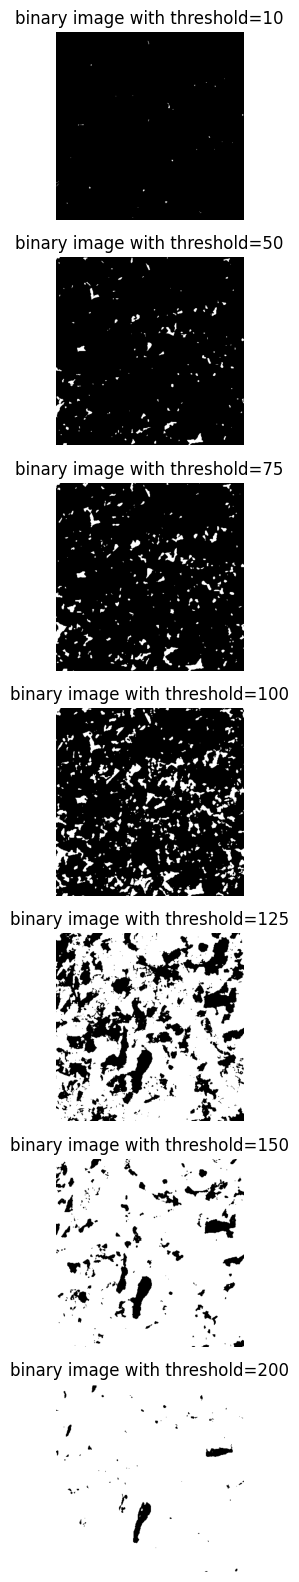

In [4]:
def plot_image(image, title=''):
    pylab.title(title, size=12), pylab.imshow(image, cmap='gray')
    pylab.axis('off') # comment this line if you want axis ticks
    
# inverse thresholding, 1 - pore, 0 - matrix
def thresholding(thresholds, img):
    plt.figure(figsize=(20,20))
    imgs = []
    for i in range(len(thresholds)):
        im_bin = np.where(img < thresholds[i], 1, 0)
        # im1 = img.point(lambda x: x < thresholds[i])
        imgs.append(im_bin)
        pylab.subplot(len(thresholds),1,i+1), plot_image(Image.fromarray(im_bin[0].astype('uint8')), 'binary image with threshold=' + str(thresholds[i]))
    pylab.show()
    return imgs


threshs = [10, 50, 75, 100, 125, 150, 200]
plt.imshow(im1[0], cmap='gray')
plt.title('original omage')
plt.show()
imgs = thresholding(threshs, im1)

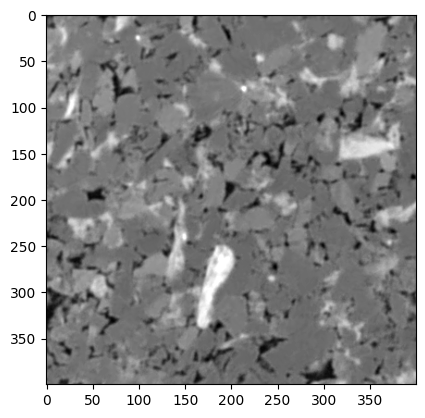

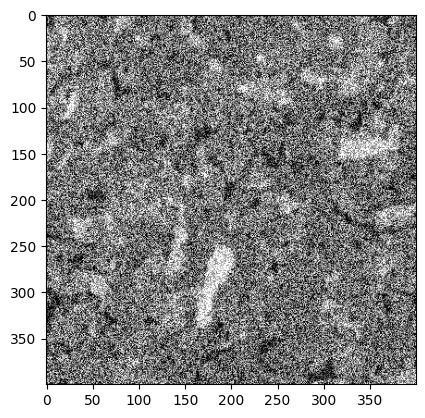

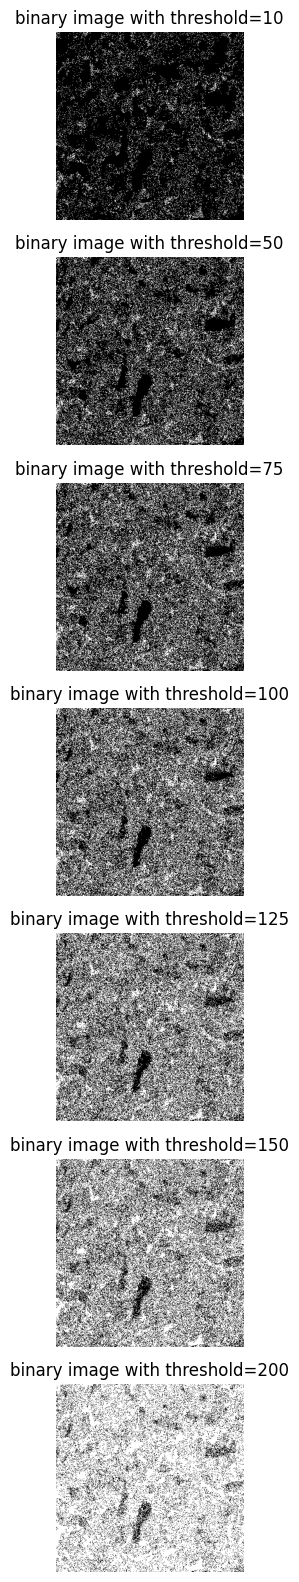

In [5]:
# add half-toning
im_noise = np.clip(im1 + np.random.randint(-128, 128, (400, 400, 400)), 0, 255).astype(np.uint8)
plt.imshow(im1[0], cmap='gray')
plt.show()
plt.imshow(im_noise[0], cmap='gray')
plt.show()
imgs_noise = thresholding(threshs, im_noise)

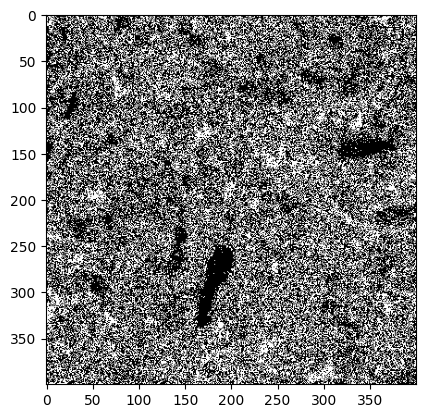

In [11]:
plt.imshow(np.array(imgs_noise[3])[0], cmap='gray')

In [12]:
# применение non-local means denoising на half-toning изображении
sigma_est = np.mean(estimate_sigma(np.array(imgs_noise[2])[0], multichannel=False))
patch_kw = dict(patch_size=5, # 5x5 patches
patch_distance=6, # 13x13 search area
multichannel=False)
denoise = denoise_nl_means(np.array(imgs_noise[2])[0], h=1.15 * sigma_est, fast_mode=True, **patch_kw)

/tmp/ipykernel_2810/3346485357.py:2: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(np.array(imgs_noise[2])[0], multichannel=False))
/tmp/ipykernel_2810/3346485357.py:6: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise = denoise_nl_means(np.array(imgs_noise[2])[0], h=1.15 * sigma_est, fast_mode=True, **patch_kw)


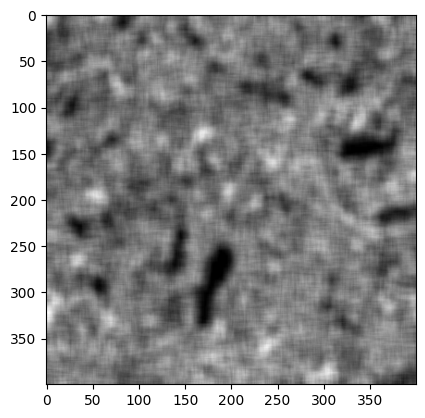

In [13]:
plt.imshow(denoise, cmap='gray')

In [14]:
ps.visualization.set_mpl_style()
np.random.seed(1)

2) Complete following tasks:
    
- Calculate porosity using porespy and manually and compare results; plot pore size distribution;
- Plot porosity profile;
- Calculate surface area;
- Calculate shape factor and plot histogram using surface area and pore volume from formula slide 8
- Plot REV (porosity vs volume);
- Plot REV (surface area vs volume) (for PhD students).

#### porosity calculation and poresize distribution

##### porosity via porespy

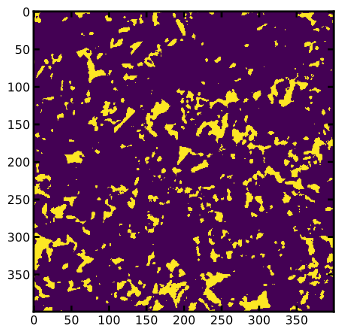

In [33]:
plt.imshow(imgs[3][0])

In [22]:
e = ps.metrics.porosity(imgs[3][0])


0.33085625


  0%|          | 0/25 [00:00<?, ?it/s]

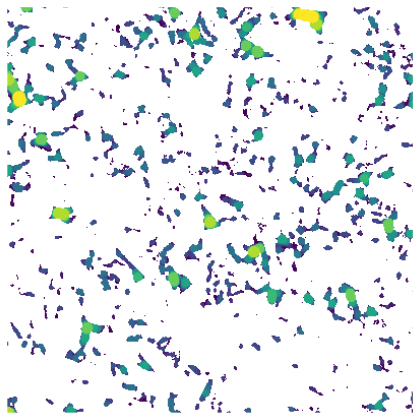

In [34]:
sizes = ps.filters.porosimetry(im=imgs[3])
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(sizes[0]/imgs[3][0], origin='lower', interpolation='none')
ax.axis(False);

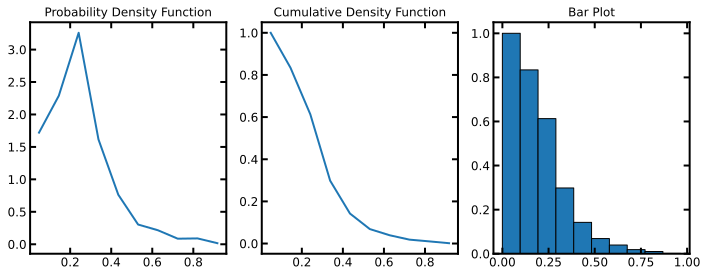

In [211]:
# The histogram of logarithm (base-10) of pore sizes is useful to plot wide size distributions 
# or to better visualize the data in the small size region.

data = ps.metrics.pore_size_distribution(im=sizes)
fig, ax = plt.subplots(1, 3, figsize=[10, 4])
ax[0].plot(data.bin_centers, data.pdf)
ax[1].plot(data.bin_centers, data.cdf)
ax[2].bar(data.bin_centers, data.cdf, data.bin_widths, edgecolor='k')
ax[0].set_title("Probability Density Function")
ax[1].set_title("Cumulative Density Function")
ax[2].set_title('Bar Plot');

In [ ]:
# prf0 = ps.metrics.porosity_profile(imgs[3], axis=0)
# prf1 = ps.metrics.porosity_profile(imgs[3], axis=1)
# prf2 = ps.metrics.porosity_profile(imgs[3], axis=2)
# plt.plot(prf0, 'b.-', label='axis0')
# plt.plot(prf1, 'g.-', label='axis1')
# plt.plot(prf2, 'c.-', label='axis2')
# # plt.plot([0, 50], [0.65, 0.65], 'r--')
# plt.xlabel('coordinate')
# plt.ylabel('porosity')
# plt.ylim([0.08, 0.2]);
# plt.legend()

##### calculation of surface area and Shape Factor

In [42]:
# Segmenting void space into regions for individual analysis
snow = ps.filters.snow_partitioning(im=imgs[3])
regions = snow.regions*snow.im

0it [00:00, ?it/s]

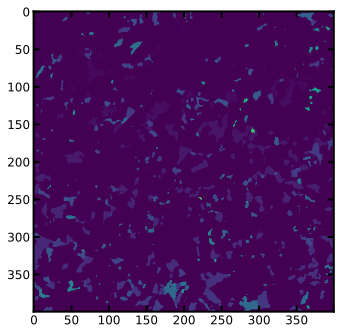

In [224]:
plt.imshow(snow.regions[0])

In [259]:
# extract information about each region using regionsprops_3d
# In order to ease computations you may take subsample from your cube

props = ps.metrics.regionprops_3D(regions[200:260, 200:260, 200:260])

In [260]:
# lets see which properties might be calculated 
r = props[3]
attrs = [a for a in r.__dir__() if not a.startswith('_')]
print(attrs)

['label', 'slice', 'mask', 'slices', 'volume', 'bbox_volume', 'border', 'dt', 'inscribed_sphere', 'sphericity', 'skeleton', 'surface_area', 'surface_mesh_vertices', 'surface_mesh_simplices', 'convex_volume', 'area', 'bbox', 'area_bbox', 'centroid', 'area_convex', 'image_convex', 'coords', 'eccentricity', 'equivalent_diameter_area', 'euler_number', 'extent', 'feret_diameter_max', 'area_filled', 'image_filled', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'image_intensity', 'centroid_local', 'intensity_max', 'intensity_mean', 'intensity_min', 'axis_major_length', 'axis_minor_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'perimeter_crofton', 'solidity', 'centroid_weighted', 'centroid_weighted_local', 'moments_weighted', 'moments_weighted_central', 'moments_weighted_hu', 'moments_weighted_normalized']


In [261]:
# lets generate a Pandas DataFrame object with all of the key metrics listed as Numpy arrays in each column

df = ps.metrics.props_to_DataFrame(props)

/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(3) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 268442020  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)
/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 268442020  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)


2023-08-27 15:10:31 | ERROR    | porespy.metrics._regionprops:props_to_DataFrame:69
--> Error encountered evaluating feret_diameter_max so skipping it


One of the ways to calculate surface area is to extract it from the dataframe

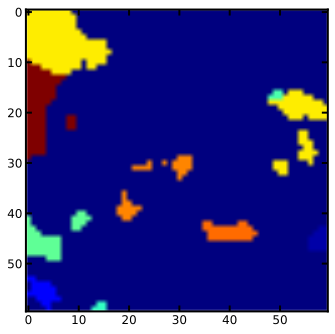

In [263]:
# Create an image colorized by surface area
# you can also use ps.metrics.region_surface_areas for calculation of surface area

sph = ps.metrics.prop_to_image(regionprops=props, shape=regions[200:260, 200:260, 200:260].shape, prop='surface_area')
fig, ax = plt.subplots()
ax.imshow((sph + 0.5*(~imgs[3][200:260, 200:260, 200:260]))[0] , cmap=plt.cm.jet);

In [300]:
# calculating shape factor using formula from presentation

In [299]:
df

,label,volume,bbox_volume,sphericity,surface_area,convex_volume,area,area_bbox,area_convex,equivalent_diameter_area,euler_number,extent,area_filled,axis_major_length,axis_minor_length,solidity
0,6749,1527,3757,0.996561,643.487000,2093,1527,3757,2093,14.287189,1,0.406441,1527,20.149931,11.055514,0.729575
1,6791,266,4416,0.266598,750.264771,1553,266,4416,1553,7.979230,5,0.060236,266,20.006540,9.852457,0.171281
2,6887,39,60,1.480609,37.562424,43,39,60,43,4.207479,1,0.650000,39,5.678858,3.263340,0.906977
3,7001,443,1155,0.616211,456.062195,675,443,1155,675,9.458052,1,0.383550,443,15.711946,7.074776,0.656296
4,7006,151,294,1.128701,121.494499,181,151,294,181,6.606825,1,0.513605,151,8.823412,4.572974,0.834254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,8834,246,1008,0.563148,337.145996,366,246,1008,366,7.774017,2,0.244048,246,11.070008,5.640099,0.672131
66,9018,153,1470,0.553745,249.824631,464,153,1470,464,6.635866,2,0.104082,153,15.074133,4.224374,0.329741
67,9043,11,30,0.588988,40.610603,14,11,30,14,2.759294,1,0.366667,11,5.681324,1.232197,0.785714
68,9263,68,1008,0.366513,219.820251,265,68,1008,265,5.064113,2,0.067460,68,11.445921,4.670830,0.256604


##### REV (PhD)

In [304]:
profile = ps.metrics.representative_elementary_volume(im=imgs[3])

  0%|          | 0/1000 [00:00<?, ?it/s]

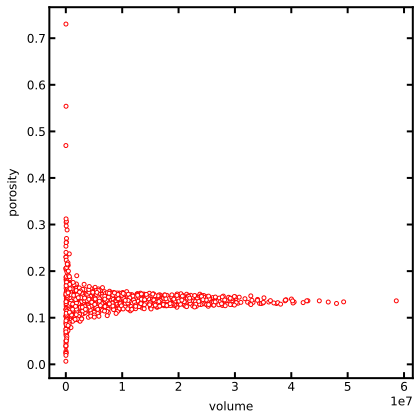

In [305]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.plot(profile.volume, profile.porosity, 'r.')
ax.set_xlabel("volume")
ax.set_ylabel("porosity");